In [ ]:
import findspark
findspark.init() 

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

import sys
from pathlib import Path

sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *
from src.feature_engineering import *

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

In [2]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")


In [3]:
df = preprocess_data(df)

In [4]:
df = preprocess_features(df)

In [5]:
df.printSchema()


root
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = false)
 |-- Start_Lng: double (nullable = false)
 |-- Distance: double (nullable = false)
 |-- State: string (nullable = false)
 |-- Timezone: string (nullable = false)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = false)
 |-- Pressure: double (nullable = false)
 |-- Visibility: double (nullable = false)
 |-- Wind_Speed: double (nullable = false)
 |-- Weather_Condition: string (nullable = false)
 |-- Amenity: boolean (nullable = true)
 |-- Bump: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Give_Way: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- No_Exit: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Roundabout: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 

In [6]:
from functools import reduce
from pyspark.sql import DataFrame
target_count = 67366

def undersample_to_target(df, target_col, target_count):
    balanced_dfs = []
    for class_value in df.select(target_col).distinct().collect():
        class_df = df.filter(df[target_col] == class_value[target_col])
        fraction = target_count / class_df.count()
        sampled_df = class_df.sample(withReplacement=False, fraction=fraction, seed=42)
        balanced_dfs.append(sampled_df)
    
    # Use reduce to union all DataFrames in the list
    balanced_df = reduce(DataFrame.union, balanced_dfs)
    return balanced_df



In [ ]:
severity_counts = df.groupBy("Severity").count().collect()
class_counts = {row["Severity"]: row["count"] for row in severity_counts}
print("Original class distribution:", class_counts)

balanced_df = undersample_to_target(df, "Severity", target_count)

new_counts = balanced_df.groupBy("Severity").count().collect()

new_counts = balanced_df.groupBy("Severity").count().collect()
new_distribution = {row["Severity"]: row["count"] for row in new_counts}
print("New class distribution after undersampling:", new_distribution)


Original class distribution: {1: 67366, 3: 1299328, 4: 204703, 2: 6156925}
New class distribution after undersampling: {1: 67366, 3: 67353, 4: 67181, 2: 67569}


In [ ]:
categorical_cols = ["Weather_Condition", "Season"]
numerical_cols = [
    "Start_Lat", "Start_Lng", "Distance", "Temperature", "Humidity", 
    "Pressure", "Visibility", "Wind_Speed", "Is_Complex_Road", 
    "Hour", "Day_of_Week", "Month", "Year", "DayOfWeek", "Duration", 
    "Is_Weekend"
]
stages = []

for cat_col in categorical_cols:
    indexer = StringIndexer(
        inputCol=cat_col,
        outputCol=f"{cat_col}_Index",
        handleInvalid="keep"
    )
    encoder = OneHotEncoder(
        inputCols=[f"{cat_col}_Index"],
        outputCols=[f"{cat_col}_OHE"]
    )
    stages += [indexer, encoder]

feature_cols = numerical_cols  + [f"{cat_col}_OHE" for cat_col in categorical_cols]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)
stages.append(assembler)

label_indexer = StringIndexer(
    inputCol="Severity",
    outputCol="label",
    handleInvalid="keep"
)
stages.append(label_indexer)

pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(balanced_df)
prepared_df = pipeline_model.transform(balanced_df)

final_df = prepared_df.select("features", "label")


In [ ]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label")
model = rf.fit(final_df)

predictions = model.transform(final_df)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)
print(f"Precision: {precision}")

recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)
print(f"Recall: {recall}")

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="f1"
)
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score}")

Accuracy: 0.6848505765041619
Precision: 0.6839358874673589
Recall: 0.6848505765041619
F1 Score: 0.6603179335386649


In [11]:
class_metrics = predictions.groupBy("label", "prediction").count().collect()
print("Confusion Matrix:")
for row in class_metrics:
    print(row)

Confusion Matrix:
Row(label=1.0, prediction=0.0, count=243)
Row(label=1.0, prediction=2.0, count=1372)
Row(label=1.0, prediction=1.0, count=65116)
Row(label=1.0, prediction=3.0, count=635)
Row(label=2.0, prediction=0.0, count=2038)
Row(label=2.0, prediction=2.0, count=44760)
Row(label=2.0, prediction=3.0, count=9796)
Row(label=2.0, prediction=1.0, count=10759)
Row(label=3.0, prediction=2.0, count=2947)
Row(label=3.0, prediction=3.0, count=53881)
Row(label=3.0, prediction=1.0, count=3477)
Row(label=3.0, prediction=0.0, count=6876)
Row(label=0.0, prediction=0.0, count=20789)
Row(label=0.0, prediction=2.0, count=20939)
Row(label=0.0, prediction=3.0, count=18917)
Row(label=0.0, prediction=1.0, count=6924)


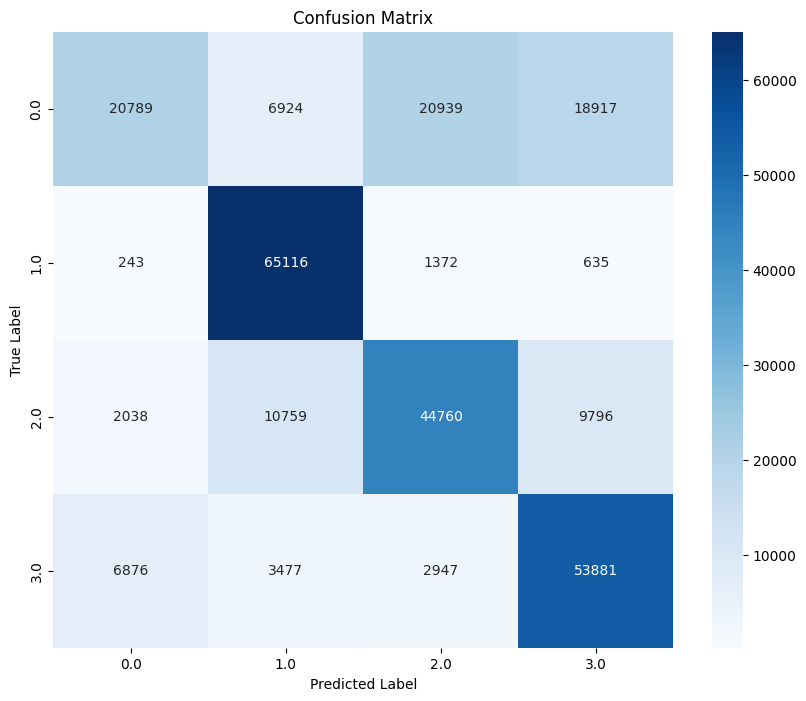

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

predictions = model.transform(final_df)

class_metrics = predictions.groupBy("label", "prediction").count().collect()

confusion_matrix_data = [{"label": row["label"], "prediction": row["prediction"], "count": row["count"]} for row in class_metrics]
df = pd.DataFrame(confusion_matrix_data)

conf_matrix = df.pivot(index="label", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
